In [1]:
from pathlib import Path

import h5py
import matplotlib.pyplot as plt
import numpy as np
import pennylane as qml
import tqdm

from pprop.propagator import Propagator

In [2]:
def ansatz(num_qubits, params, depth):
    p_idx = 0

    for d in range(depth):
        for q in range(num_qubits):
            qml.RY(params[p_idx], wires=q)
            p_idx += 1

        for qc, qt in zip(range(0, num_qubits, 2), range(1, num_qubits, 2)):
            qml.CNOT(wires=[qc, qt])

        for q in range(num_qubits):
            qml.RX(params[p_idx], wires=q)
            p_idx += 1

        for qc, qt in zip(range(1, num_qubits, 2), range(2, num_qubits, 2)):
            qml.CNOT(wires=[qc, qt])

    for q in range(num_qubits):
        qml.RY(params[p_idx], wires=q)
        p_idx += 1

    return qml.expval(qml.PauliZ(num_qubits - 1))

nq = 8
depth = 3

In [3]:
prop = Propagator(lambda p:ansatz(nq, p, depth), k1=None, k2=None)
prop

Propagator
  Number of qubits : 8
  Trainable parameters : 56
  Cutoff 1: None | Cutoff 2: None
  Observables [Z(7)]
0: ──RY─╭●──RX──RY─────╭●──RX──RY─────╭●──RX──RY─────┤     
1: ──RY─╰X──RX─╭●───RY─╰X──RX─╭●───RY─╰X──RX─╭●───RY─┤     
2: ──RY─╭●──RX─╰X───RY─╭●──RX─╰X───RY─╭●──RX─╰X───RY─┤     
3: ──RY─╰X──RX─╭●───RY─╰X──RX─╭●───RY─╰X──RX─╭●───RY─┤     
4: ──RY─╭●──RX─╰X───RY─╭●──RX─╰X───RY─╭●──RX─╰X───RY─┤     
5: ──RY─╰X──RX─╭●───RY─╰X──RX─╭●───RY─╰X──RX─╭●───RY─┤     
6: ──RY─╭●──RX─╰X───RY─╭●──RX─╰X───RY─╭●──RX─╰X───RY─┤     
7: ──RY─╰X──RX──RY─────╰X──RX──RY─────╰X──RX──RY─────┤  <Z>

In [4]:
prop.propagate()

Propagating Z(7): 100%|██████████| 1/1 [00:00<00:00, 12.12it/s]


In [5]:
def get_approx(prop_full, W = [2,3,4], V = [2,3,4], obs_idx = 0, num_samples = 10000):
    prop_dicts = {}
    err_dict = {}
    for w in W:
        for v in V:
            prop_approx = Propagator(lambda p:ansatz(nq, p, depth), k1=w, k2=v)
            prop_approx.propagate()
            prop_dicts[(w,v)] = prop_approx
            err_dict[(w,v)] = []
    
    for _ in tqdm.tqdm(range(num_samples)):
        p = np.random.random(prop_full.num_params) * 4 * np.pi
        true = prop_full.eval(p)[obs_idx]

        for w in W:
            for v in V:
                approx = prop_dicts[(w,v)].eval(p)[obs_idx]
                err_dict[(w,v)].append((approx - true)**2)

    return err_dict

100%|██████████| 10000/10000 [00:04<00:00, 2120.18it/s]


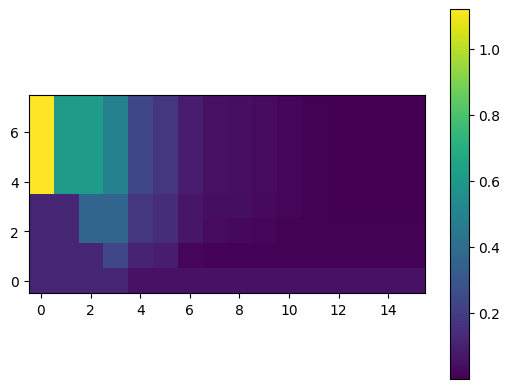

In [6]:
W = [1,2,3,4,5,6,7,8]
V = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]
err_dict = get_approx(prop, W = W, V = V, obs_idx = 0, num_samples = 10000)

err_imshow = np.zeros((len(W), len(V)))
for i, w in enumerate(W):
    for j, v in enumerate(V):
        err_imshow[i,j] = np.mean(err_dict[(w,v)])
        
plt.imshow(err_imshow, origin='lower')
plt.colorbar()
plt.show()